# アメダスデータ

指定した水平地点の近くのアメダスデータを取得し, 時系列を描くノートブックです.

以下サイトを参考にしています.
* 過去データURLの取得 https://qiita.com/OSAKO/items/d25b8484d35ef4fe19e0
* 過去データURLにアクセスしデータ取得 https://qiita.com/tmiyama/items/f9cec233049b42f32965
* 地点情報の取得 https://www.dpac.dpri.kyoto-u.ac.jp/enomoto/pymetds/index.html

### ※ 現状, 観測地点による保持変数の違いや時刻ごとの欠損値などの処理はまだできてません. またhourlyのみです.


## ライブラリの読込
* numpy: 数値計算ライブラリ
* matplotlib: 描画ライブラリ
* pandas: データ処理ライブラリ
* urllib: スクレイピング関係
* bs4: スクレイピング関係

スクレイピング周りでエラーが出た際はlxml, html5libをインストールすると解決する可能性がある. ( https://prograshi.com/language/python/python-pandas-read_html-errors-debug/ ).
例えば, condaを使っている場合「conda install -c conda-forge lxml」や「conda install html5lib」

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import requests
import datetime
import urllib.request
from bs4 import BeautifulSoup

plt.rcParams["font.size"]=15

## 設定
* 地点の指定は, 適当な緯度・経度か, アメダス観測地点名. 前者の場合, 最も近いアメダス地点を同定して使用する.
* 現状, hourlyデータのみ対応している. 年・月・日を指定する.

In [2]:
savefig = True
dir_out = "./fig/"

# Target location
by_target_pos = True
# r-ccs
#lon0 = 135.2207105
#lat0 = 34.6533937
# tokyo station
#lon0 = 139.7671248
#lat0 = 35.6812362
# tsukuba
lon0 = 140.1115746
lat0 = 36.0827355

by_target_name = not by_target_pos
tname = "東京"
#tname = "神戸"

# Target period
year = 2007
month = 7
day = 15
#year = 2024
#month = 6
#day = 1

datatype0="hourly"

if by_target_name==by_target_pos:
    print("CAUTION: Only one of 'by_target_name' or 'by_target_pos' should be True")


## 地点情報の取得(今回はこの方法は使わない)

* #気象庁サイトから観測地点名と観測地点座標を取得

In [3]:
#url = "https://www.jma.go.jp/bosai/amedas/const/amedastable.json"
#with requests.get(url) as response:
#    json = response.json()
#    df = pd.DataFrame(json).transpose()
#
#df["lat"] = df["lat"].str[0] + df["lat"].str[1]/60
#df["lon"] = df["lon"].str[0] + df["lon"].str[1]/60
#lat = df["lat"].values
#lon = df["lon"].values

## 過去データURLを取得

* 気象庁サイトからURLを同定するための情報を取得
* 地域area・地域リンクarea_linkを取得
* 地域area・地域リンクarea_linkについてのループのなかで, 観測地点station・観測地点リンクstation_link・観測地点その他情報(位置情報など)station_etcを取得

In [4]:

url = 'https://www.data.jma.go.jp/obd/stats/etrn/select/prefecture00.php?prec_no=&block_no=&year=&month=&day=&view='
html = urllib.request.urlopen(url)
soup = BeautifulSoup(html, 'html.parser')
elements = soup.find_all('area')
area_list = [element['alt'] for element in elements]
area_link_list = [element['href'] for element in elements]

total_station_list = [] 
total_station_link_list = []
total_station_etc_list = []

ind = 0
for area, area_link in zip(area_list, area_link_list):
    url = 'https://www.data.jma.go.jp/obd/stats/etrn/select/'+ area_link
    print(ind)
    print("Area:", area, url)
    
    html = urllib.request.urlopen(url)
    soup = BeautifulSoup(html, 'html.parser')
    elements = soup.find_all('area')
    station_etc_list = []
    station_list = []
    station_link_list = []
    for element in elements:
        try:
            station_etc_list.append(element["onmouseover"])
            station_list.append(element['alt'])
            station_link_list.append(element['href'].strip('../'))
        except KeyError:
            pass

    print("Station:", station_list[::2])
    print("\n")
    total_station_list.append(station_list[::2])
    total_station_link_list.append(station_link_list[::2])
    total_station_etc_list.append(station_etc_list[::2])

    ind +=1
    
total_station_list_flatten = [tmp1 for tmp2 in total_station_list for tmp1 in tmp2]
total_station_link_list_flatten = [tmp1 for tmp2 in total_station_link_list for tmp1 in tmp2]
total_station_etc_list_flatten = [tmp1 for tmp2 in total_station_etc_list for tmp1 in tmp2]

0
Area: 宗谷地方 https://www.data.jma.go.jp/obd/stats/etrn/select/prefecture.php?prec_no=11&block_no=&year=&month=&day=&view=
Station: ['稚内', '沓形', '浜頓別', '北見枝幸', '歌登', '中頓別', '豊富', '沼川', '船泊', '宗谷岬', '浜鬼志別', '本泊', '声問', '礼文', '幌泊', '幌延', '礼文上泊埼']


1
Area: 上川地方 https://www.data.jma.go.jp/obd/stats/etrn/select/prefecture.php?prec_no=12&block_no=&year=&month=&day=&view=
Station: ['美深', 'ピヤシリ山', '名寄', '西風連', '下川', '士別', '犬牛別峠', '雄鷹峰', '蓬莱山', '上川', '旭川', '瑞穂', '終沢', '旭岳', '白金', '富良野', '前富良野岳', '前時雨山', '朝日', '比布', '層雲峡', '美瑛', '和寒', '東川', '志比内', '幾寅', '占冠', '上富良野', '江丹別', '音威子府', '中川', '麓郷', '東神楽', '小車', '剣淵', '金山', '幌加内', '朱鞠内']


2
Area: 留萌地方 https://www.data.jma.go.jp/obd/stats/etrn/select/prefecture.php?prec_no=13&block_no=&year=&month=&day=&view=
Station: ['天塩', '遠別', '羽幌', '留萌', '増毛', '古丹別', '焼尻', '初山別', '達布', '幌糠']


3
Area: 石狩地方 https://www.data.jma.go.jp/obd/stats/etrn/select/prefecture.php?prec_no=14&block_no=&year=&month=&day=&view=
Station: ['阿曽岩', '新篠津', '山口', '手稲山', '札幌', '小金湯', 

* 観測地点タイプstype・緯度lat・経度lonを取得

In [5]:
# extract stationtype, lat, lon information
total_station_type_list_flatten = [etc.split("javascript:viewPoint(")[1].split(",")[0][1] for etc in total_station_etc_list_flatten]
total_station_lat_list_flatten = [float(etc.split("javascript:viewPoint(")[1].split(",")[4][1:-1]) + float(etc.split("javascript:viewPoint(")[1].split(",")[5][1:-1])/60  for etc in total_station_etc_list_flatten]
total_station_lon_list_flatten = [float(etc.split("javascript:viewPoint(")[1].split(",")[6][1:-1]) + float(etc.split("javascript:viewPoint(")[1].split(",")[7][1:-1])/60  for etc in total_station_etc_list_flatten]

stype = np.array(total_station_type_list_flatten)
lat = np.array(total_station_lat_list_flatten)
lon = np.array(total_station_lon_list_flatten)


* ターゲットに近い観測地点を同定; by_target_pos

あるいは

* 観測地点名からインテックス取得; by_target_name

In [6]:
# Calculate distance from target
def ll2dist(lat1,lon1,lat2,lon2):
    R = 6371
    return R * np.arccos(
        np.sin(np.radians(lat1))*np.sin(np.radians(lat2))
        +np.cos(np.radians(lat1))*np.cos(np.radians(lat2))*
        np.cos(np.radians(lon1)-np.radians(lon2)))

if by_target_pos:
    dist = ll2dist(lat0,lon0,lat,lon)
    argmin_dist = np.argmin(dist)
    station_index = argmin_dist
if by_target_name:
    station_index  = total_station_list_flatten.index(tname)

#info_argmin_dist = df.values[argmin_dist,:]
#name_argmin_dist = info_argmin_dist[5]
#print(info_argmin_dist)

# 
station = total_station_list_flatten[station_index]
station_link = total_station_link_list_flatten[station_index]
stype0 = stype[station_index]
lon_target = lon[station_index]
lat_target = lat[station_index]

block_no_str = station_link.split("block_no=")[1].split("&")[0]

datatype = datatype0 + f"_{stype0}1.php?"
url = "https://www.data.jma.go.jp/obd/stats/etrn/view/" + datatype + station_link.split("?")[1].replace("year=",f"year={year}").replace("month=",f"month={month}").replace("day=",f"day={day}")
print(station, f"({lon_target},{lat_target})" ,datatype[:-5], url)
#url="https://www.data.jma.go.jp/obd/stats/etrn/view/monthly_a1.php?prec_no=82&block_no=0780&year=1983&month=&day=&view="


つくば（館野） (140.125,36.056666666666665) hourly_s1 https://www.data.jma.go.jp/obd/stats/etrn/view/hourly_s1.php?prec_no=40&block_no=47646&year=2007&month=7&day=15&view=


* データ取得地点の確認

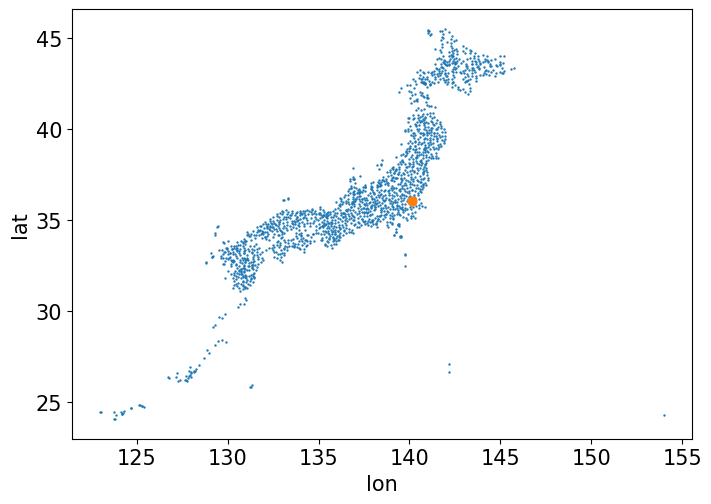

In [7]:
# check station location
fig,ax=plt.subplots(figsize=(8,6))
ax.scatter(lon[:-1],lat[:-1],s=0.5) # here the last station "showa" is excluded for visibility
ax.scatter(lon_target,lat_target,s=40)
ax.set_xlabel("lon")
ax.set_ylabel("lat")
ax.set_aspect("equal")
#ax.set_xlim(135,145)
#ax.set_ylim(30,40)


* データ抽出

※ 現時点で, hourlyデータのみ. また, 観測地点ごとの保持変数の違いに対応していない.

In [8]:
table=pd.read_html(url)
df=table[0]

time = df["時"].values[:,0]
time = time.astype(float)

jstdatetimelist = [datetime.datetime(year,month,day) + datetime.timedelta(hours=tmp) for tmp in time]
utcdatetimelist = [tmp-datetime.timedelta(hours=9)  for tmp in jstdatetimelist]
time_target = jstdatetimelist[0].strftime("%Y-%m-%d ")

varname_j = "降水量 (mm)"
varname = "PREC"
varunit = "(mm)"
#varname_j = "気温 (℃)"
#varname = "T2"
#varunit = "(℃)"

prec = df[varname_j].values[:,0]
#print("check prec.dtype, 1", prec.dtype)
if prec.dtype == 'O':
    if "--" in prec:
        print("※ 「--」：該当現象、または該当現象による量等がない場合に表示します。 https://www.data.jma.go.jp/obd/stats/data/mdrr/man/remark.html")
        prec[prec=="--"]=np.nan
    if "///" in prec:
        print("※ 「///」：欠測または観測を行っていない場合、欠測または観測を行っていないために合計値や平均値等が求められない場合に表示します。　https://www.data.jma.go.jp/obd/stats/data/mdrr/man/remark.html")
        prec[prec=="///"]=np.nan
prec = prec.astype(float)
#print("check prec.dtype, 2", prec.dtype)

#df.columns
#df

※ 「--」：該当現象、または該当現象による量等がない場合に表示します。 https://www.data.jma.go.jp/obd/stats/data/mdrr/man/remark.html


## 描画

つくば（館野） hourly_s1 https://www.data.jma.go.jp/obd/stats/etrn/view/hourly_s1.php?prec_no=40&block_no=47646&year=2007&month=7&day=15&view=


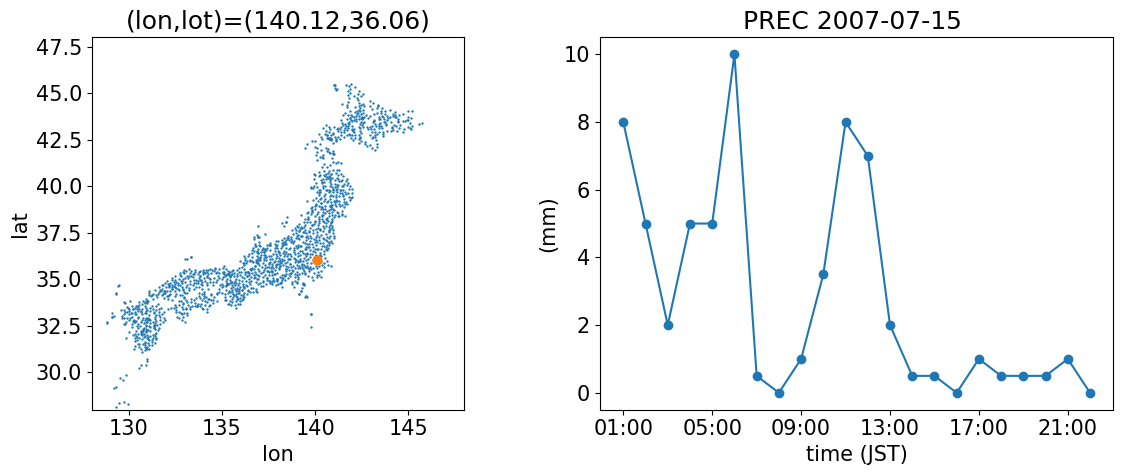

In [9]:
time = np.arange(prec.size)


fig,axes=plt.subplots(1,2,figsize=(12,5))
ax = axes[1]
ax.plot(time,prec,marker="o")
ax.set_xticks(time[::4])
ax.set_xticklabels([jstdatetime.strftime("%H:%M") for jstdatetime in jstdatetimelist][::4])
ax.set_title(varname + " " + time_target)
ax.set_ylabel(varunit)
ax.set_xlabel("time (JST)")

#fig,ax=plt.subplots(figsize=(8,6))
ax = axes[0]
ax.scatter(lon[:-1],lat[:-1],s=0.5) # here the last station "showa" is excluded for visibility
ax.scatter(lon_target,lat_target,s=40)
ax.set_xlabel("lon")
ax.set_ylabel("lat")
ax.set_aspect("equal")
ax.set_xlim(128,148)
ax.set_ylim(28,48)
ax.set_title(f"(lon,lot)=({lon_target:.2f},{lat_target:.2f})")

fig.tight_layout()
if savefig:
    fnamelabel = f"Amedas_{varname}_{time_target}_lon{lon_target}_lat{lat_target}_{station}"
    fig.savefig(dir_out+ fnamelabel + ".png")

print(station, datatype[:-5], url)

In [10]:
df

時 気圧(hPa)         降水量 (mm) 気温 (℃) 露点 温度 (℃) 蒸気圧 (hPa) 湿度 (％) 風向・風速(m/s)  \
     時      現地      海面 降水量 (mm) 気温 (℃) 露点 温度 (℃) 蒸気圧 (hPa) 湿度 (％)         風速   
0    1   999.8  1003.4      8.0   22.0      21.5      25.6     97        3.7   
1    2   997.8  1001.4      5.0   22.1      21.6      25.8     97        4.0   
2    3   997.0  1000.6      2.0   22.0      21.5      25.6     97        3.8   
3    4   996.0   999.5      5.0   21.9      21.4      25.5     97        3.6   
4    5   995.1   998.6      5.0   21.8      21.3      25.3     97        4.2   
5    6   994.2   997.7     10.0   21.9      21.4      25.5     97        3.7   
6    7   992.9   996.4      0.5   22.3      21.8      26.1     97        4.6   
7    8   992.3   995.8      0.0   22.7      22.2      26.8     97        3.5   
8    9   990.8   994.3      1.0   23.8      23.1      28.3     96        3.3   
9   10   988.7   992.2      3.5   25.2      24.3      30.4     95        4.3   
10  11   986.0   989.5      8.0   24.7      23.7      29.3     94        6.2   
11  12   984.3   987.8      7.0   25.0      24.1      30.0     95        6.1   
12  13   982.9   986.4      2.0   25.0      24.3      30.4     96        3.1   
13  14   981.8   985.3      0.5   25.0      24.1      30.0     95        3.3   
14  15   981.2   984.7      0.5   25.1      24.4      30.6     96        4.2   
15  16   981.5   985.0      0.0   24.1      23.4      28.8     96        5.1   
16  17   982.4   985.9      1.0   23.4      22.5      27.2     95        6.8   
17  18   983.6   987.1      0.5   22.9      21.9      26.3     94        6.9   
18  19   985.5   989.0      0.5   22.1      20.7      24.4     92        5.2   
19  20   987.1   990.6      0.5   21.6      20.6      24.3     94        4.7   
20  21   989.0   992.5      1.0   20.9      19.9      23.2     94        5.4   
21  22   990.0   993.5      0.0   21.4      19.5      22.7     89        4.6   
22  23   991.0   994.5       --   22.1      19.3      22.4     84        4.1   
23  24   991.6   995.1       --   22.4      18.8      21.7     80        4.4   

        日照 時間 (h) 全天 日射量 (MJ/㎡) 雪(cm)       天気    雲量 視程 (km)  
     風向 日照 時間 (h) 全天 日射量 (MJ/㎡)    降雪   積雪  天気    雲量 視程 (km)  
0     東       NaN           NaN   NaN  NaN NaN   NaN     NaN  
1     東       NaN           NaN   NaN  NaN NaN   NaN     NaN  
2   東北東       NaN           NaN   NaN  NaN NaN   NaN     NaN  
3   東北東       NaN           NaN   NaN  NaN NaN   NaN     NaN  
4    北東        --          0.00   NaN  NaN NaN   NaN     NaN  
5    北東        --          0.06   NaN  NaN NaN   NaN     NaN  
6    北東        --          0.21   NaN  NaN NaN   NaN     NaN  
7   東北東        --          0.26   NaN  NaN NaN   NaN     NaN  
8   東北東        --          0.49    --   -- NaN  10.0     8.0  
9   東南東        --          0.32   NaN  NaN NaN   NaN     NaN  
10  東南東        --          0.49   NaN  NaN NaN   NaN     NaN  
11   南東        --          0.47   NaN  NaN NaN   NaN     NaN  
12    東        --          0.71   NaN  NaN NaN   NaN     NaN  
13  東北東        --          0.67   NaN  NaN NaN   NaN     NaN  
14   北東        --          0.96    --   -- NaN  10.0     4.0  
15    北        --          0.54   NaN  NaN NaN   NaN     NaN  
16  北北東        --          0.29   NaN  NaN NaN   NaN     NaN  
17  北北東        --          0.25   NaN  NaN NaN   NaN     NaN  
18    北        --          0.04   NaN  NaN NaN   NaN     NaN  
19  北北西       NaN          0.00   NaN  NaN NaN   NaN     NaN  
20  北北西       NaN           NaN   NaN  NaN NaN   NaN     NaN  
21    北       NaN           NaN   NaN  NaN NaN   NaN     NaN  
22    北       NaN           NaN   NaN  NaN NaN   NaN     NaN  
23    北       NaN           NaN   NaN  NaN NaN   NaN     NaN